In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/datasets

/content/drive/MyDrive/datasets


In [ ]:
#проверяем наличие доступного графического процессора (GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Если GPU доступен, переменной device присваивается значение 'cuda', что означает использование GPU для вычислений. Если GPU недоступен, переменной device присваивается значение 'cpu', что означает использование центрального процессора (CPU) для вычислений.

## 1. Генерирование русских имен при помощи RNN

In [ ]:
#загружаем данные из файла
names = pd.read_csv("/content/drive/MyDrive/datasets/name_rus.txt", encoding="cp1251", header=None, names=["name"])
names.name = names.name.str.lower().str.strip() #приводим все строки к нижнему регистру и удаляем пробелы в начале и конце строк
names

,name
0,авдокея
1,авдоким
2,авдоня
3,авдотька
4,авдотьюшка
...,...
1983,ярополк
1984,ярослав
1985,ярослава
1986,ярославка


Датасет: https://disk.yandex.ru/i/2yt18jHUgVEoIw

1.1 На основе файла name_rus.txt создайте датасет.
  * Учтите, что имена могут иметь различную длину
  * Добавьте 4 специальных токена: 
    * `<PAD>` для дополнения последовательности до нужной длины;
    * `<UNK>` для корректной обработки ранее не встречавшихся токенов;
    * `<SOS>` для обозначения начала последовательности;
    * `<EOS>` для обозначения конца последовательности.
  * Преобразовывайте строку в последовательность индексов с учетом следующих замечаний:
    * в начало последовательности добавьте токен `<SOS>`;
    * в конец последовательности добавьте токен `<EOS>` и, при необходимости, несколько токенов `<PAD>`;
  * `Dataset.__get_item__` возращает две последовательности: последовательность для обучения и правильный ответ. 
  
  Пример:
  ```
  s = 'The cat sat on the mat'
  # преобразуем в индексы
  s_idx = [2, 5, 1, 2, 8, 4, 7, 3, 0, 0]
  # получаем x и y (__getitem__)
  x = [2, 5, 1, 2, 8, 4, 7, 3, 0]
  y = [5, 1, 2, 8, 4, 7, 3, 0, 0]
  ```

In [ ]:
#создаем класс, который используется для создания словаря на основе имен, переданных в конструкторе
class Vocab:
    def __init__(self, names):
        xs = names.iloc[:, 0] #извлекаем первый столбец
        self.max_seq_len = xs.str.len().max() #находим максимальную длину строки
        tokens = set() #создаем пустое множество
        for name in xs:
            tokens.update(name) #добавляем каждый символ из текущего имени в множество
            #создаем словарь, в котором ключами являются целочисленные индексы, начиная с 4,а значениями - символы из множества tokens:
        self.idx_to_token = dict(enumerate(tokens, 4))  #т.е. каждому символу присваивается уникальный индекс
        # добавляем специальные символы в словарь:
        self.idx_to_token[0] = "<PAD>" #представляет пустые символы для заполнения последовательностей
        self.idx_to_token[1] = "<UNK>" #представляет неизвестные символы
        self.idx_to_token[2] = "<SOS>" #представляет начало последовательности
        self.idx_to_token[3] = "<EOS>" #представляет конец последовательности
        #создаем обратное отображение, где символы являются ключами, а индексы - значениями:
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()} #т.е. можно быстро получить индекс символа, зная сам символ
        self.vocab_len = len(self.idx_to_token) #сохраняем общее количество уникальных символов (длину словаря) 

In [ ]:
#создаем класс, который представляет собой пользовательский датасет для работы с именами на русском языке
class RusNamesDataset(Dataset):
    def __init__(self, X, vocab: Vocab):
        self.X = X #сохраняется список имен X
        self.vocab = vocab #сохраняется объект класса Vocab

    def vectorize(self, surname): #преобразование фамилии в вектор, состоящий из числовых индексов
        surname = surname[:vocab.max_seq_len] #обрезаем фамилию до максимальной длины
        surname_t = torch.zeros(self.vocab.max_seq_len+2).type(torch.long) #создаем пустой тензор 
        surname_t += self.vocab.token_to_idx["<PAD>"] #все элементы тензора заполняем значением индекса символа <PAD>
        for i, token in enumerate(surname, 1): #перебираем символы в обрезанной фамилии
            #если символ token присутствует в словаре, то соответствующему элементу в тензоре surname_t присваивается индекс этого символа
            try:
                surname_t[i] = self.vocab.token_to_idx[token]
            #если символ отсутствует в словаре (IndexError), то присваивается индекс символа <UNK> (неизвестный символ)
            except IndexError as e:
                surname_t[i] = self.vocab.token_to_idx["<UNK>"]
        #устанавливаем первый и последний элементы тензора равными индексам символов <SOS> и <EOS>
        surname_t[0] = self.vocab.token_to_idx["<SOS>"]
        surname_t[-1] = self.vocab.token_to_idx["<EOS>"]
        return surname_t[:-1], surname_t[1:]
        #возвращаем в виде кортежа, содержащего два тензора: 
        #первый с символами фамилии за исключением последнего символа и второй с символами фамилии за исключением первого символа

    def __len__(self): #возвращаем длину датасета, то есть количество имен в списке
        return len(self.X)

    def __getitem__(self, idx): #получаем элемент датасета по индексу 
        return self.vectorize(self.X[idx])

In [ ]:
vocab = Vocab(names) #создаем объект, который служит для создания словаря на основе имен
dataset = RusNamesDataset(names.name.values, vocab) #создаем объект, который представляет собой пользовательский датасет для работы с именами на русском языке
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) #создаем объект, который служит для эффективной загрузки данных из датасета в модель обучения

1.2 Создайте и обучите модель для генерации фамилии.

  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`;
  * Используйте рекуррентные слои;
  * Задача ставится как предсказание следующего токена в каждом примере из пакета для каждого момента времени. Т.е. в данный момент времени по текущей подстроке предсказывает следующий символ для данной строки (задача классификации);
  * Примерная схема реализации метода `forward`:
  ```
    input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
    emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size] 
    output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
    output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
  ```

In [ ]:
#создаем класс, который представляет собой модель нейронной сети для обработки имен на русском языке
class MyModel(nn.Module):
    def __init__(self, vocab_len, embedding_dim, hidden_size, padding_idx, num_layers=1):
        super(MyModel, self).__init__()
        #слой эмбеддингов (nn.Embedding), который отображает индексы символов в векторные представления заданной размерности
        self.embedding = nn.Embedding(padding_idx=padding_idx, num_embeddings=vocab_len, embedding_dim=embedding_dim)
        # слой рекуррентной нейронной сети (nn.RNN), который принимает векторные представления символов и вычисляет скрытые состояния RNN
        self.rnn = nn.RNN(num_layers=num_layers, batch_first=True, input_size=embedding_dim, hidden_size=hidden_size)
        #полносвязный слой (nn.Linear), который преобразует скрытые состояния RNN в векторные представления символов
        self.fc = nn.Linear(in_features=hidden_size, out_features=vocab_len)
    
    def forward(self, x, h=None): #определяет проход данных через модель
        x = self.embedding(x) #тензор с индексами символов
        x, h = self.rnn(x, h) #скрытое состояние RNN
        x = self.fc(x) #предсказания для каждого символа в словаре
        return x, h

In [ ]:
model = MyModel(
    vocab_len=vocab.vocab_len,
    embedding_dim=32,
    hidden_size=64,
    padding_idx=vocab.token_to_idx["<PAD>"],
)
criterion = nn.CrossEntropyLoss() #используется для вычисления потери (ошибки) между предсказанными значениями и истинными метками
optimizer = optim.Adam(params=model.parameters(), lr=0.001) #используется для получения параметров модели, которые будут оптимизироваться

In [ ]:
#обучение модели
epoch_step = 10 #шаги вывода информации о потере
n_epochs = 101
epoch_list = []
loss_list = []
for epoch in range(n_epochs):
    #создаем пустые тензоры для хранения предсказанных значений и истинных меток классов
    y_pred = torch.empty(0)
    y_true = torch.empty(0, dtype=torch.long)
    #переводим модель в режим обучения
    model.train()
    #итерация по пакетам данных из объекта dataloader
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad() #обнуляем накопленные градиенты
        predictions, h = model(X_batch) #вызываем модель, чтобы получить предсказания и скрытое состояние
        loss = criterion(predictions.transpose(1, -1), y_batch) #вычисляем потери (ошибки)
        loss.backward() #вычисляем градиенты функции потерь по параметрам модели
        optimizer.step() #обновляем параметры модели, применение градиента
        with torch.no_grad(): #вычисляем предсказанные значений y_pred и истинные меток y_true
            y_true = torch.cat((y_true, y_batch))
            y_pred = torch.cat((y_pred, predictions))
    with torch.no_grad(): #вычисляем потерю обучения
        train_loss = criterion(y_pred.transpose(1, -1), y_true).item()
    #если текущая эпоха epoch кратна epoch_step, выводится информация о потере обучения на текущей эпохе
    if epoch % epoch_step == 0:
        epoch_list.append(epoch)
        loss_list.append(train_loss)
        print(f"#{epoch:3d} --- loss [{train_loss:.4f}]")

#  0 --- loss [0.6393]
# 10 --- loss [0.6357]
# 20 --- loss [0.6350]
# 30 --- loss [0.6349]
# 40 --- loss [0.6275]
# 50 --- loss [0.6363]
# 60 --- loss [0.6264]
# 70 --- loss [0.6218]
# 80 --- loss [0.6186]
# 90 --- loss [0.6174]
#100 --- loss [0.6149]


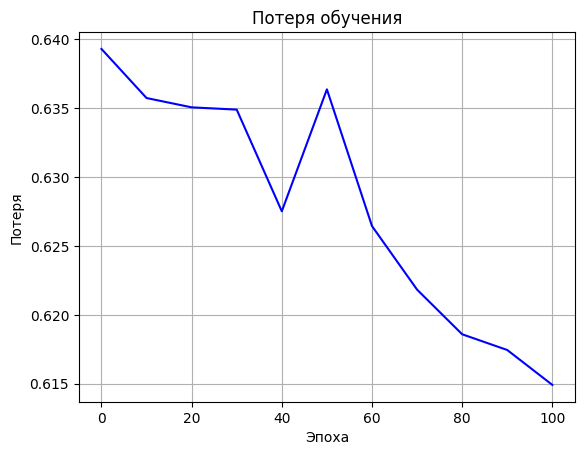

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, loss_list, 'b-')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Потеря обучения')
plt.grid(True) #добавляем сетку
plt.show()

1.3 Напишите функцию, которая генерирует фамилию при помощи обученной модели:
  * Построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * Начальное скрытое состояние RNN `h_t = None`;
  * В результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * Выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * Повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности.

При обучении каждые `k` эпох генерируйте несколько фамилий и выводите их на экран.

In [ ]:
#создаем класс, который представляет модель для генерации случайных слов на основе заданного словаря
class MyModel(nn.Module):
    def __init__(self, vocab, embedding_dim, hidden_size, num_layers=1):
        super(MyModel, self).__init__()
        self.vocab = vocab
        #слой эмбеддингов (nn.Embedding), который отображает индексы символов в векторные представления заданной размерности
        self.embedding = nn.Embedding(padding_idx=vocab.token_to_idx["<PAD>"], num_embeddings=vocab.vocab_len, embedding_dim=embedding_dim)
        #слой рекуррентной нейронной сети (nn.RNN), который принимает векторные представления символов и вычисляет скрытые состояния RNN
        self.rnn = nn.RNN(num_layers=num_layers, batch_first=True, input_size=embedding_dim, hidden_size=hidden_size)
        #полносвязный слой (nn.Linear), который преобразует скрытые состояния RNN в векторные представления символов
        self.fc = nn.Linear(in_features=hidden_size, out_features=vocab.vocab_len)
    
    def forward(self, x, h=None): #определяем проход данных через модель
        x = self.embedding(x) #тензор с индексами символов
        x, h = self.rnn(x, h) #скрытое состояние RNN
        x = self.fc(x) #предсказания для каждого символа в словаре
        return x, h
    
    def random_word(self): #метод используется для генерации случайного слова
        h = None
        word = []
        token = torch.tensor([[vocab.token_to_idx["<SOS>"]]])
        for _ in range(self.vocab.max_seq_len): #происходит генерация символов до достижения максимальной длины слова
            out, h = self(token, h)
            #выход модели преобразуется с помощью softmax и выбирается случайным образом новый токен
            out_random = out.squeeze().softmax(-1).multinomial(1)
            letter = self.vocab.idx_to_token[out_random.item()]
            if letter == "<EOS>":
                break
            word.append(letter)
            token = out_random.view(1, 1)
        #создается список clear, содержащий символы из word, за исключением специальных токенов
        clear = [letter for letter in word if letter not in ["<PAD>","<EOS>","<SOS>","<UNK>"]]
        #создается строка generated из символов в списке word, начинающаяся с заглавной буквы
        generated = "".join(word).capitalize()
        #создается строка clear, полученная из символов в списке clear, начинающаяся с заглавной буквы
        clear = "".join(clear).capitalize()
        return generated, clear

In [ ]:
model = MyModel(
    vocab=vocab,
    embedding_dim=32,
    hidden_size=64,
)
criterion = nn.CrossEntropyLoss() #используется для вычисления потери (ошибки) между предсказанными значениями и истинными метками
optimizer = optim.Adam(params=model.parameters(), lr=0.001) #используется для получения параметров модели, которые будут оптимизироваться

In [ ]:
#обучение модели
epoch_step = 10
n_epochs = 101
n_words = 10 #количество сгенерированных слов
epoch_list = []
loss_list = []
for epoch in range(n_epochs):
    #создаем пустые тензоры для хранения предсказанных значений и истинных меток классов
    y_pred = torch.empty(0)
    y_true = torch.empty(0, dtype=torch.long)
    #переводим модель в режим обучения
    model.train()
    #итерация по пакетам данных из объекта dataloader
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad() #обнуляем накопленные градиенты
        predictions, h = model(X_batch) #вызываем модель, чтобы получить предсказания и скрытое состояние
        loss = criterion(predictions.transpose(1, -1), y_batch) #вычисляем потери (ошибки)
        loss.backward() #вычисляем градиенты функции потерь по параметрам модели
        optimizer.step() #обновляем параметры модели, применение градиента
        with torch.no_grad(): #вычисляем предсказанные значений y_pred и истинные меток y_true
            y_true = torch.cat((y_true, y_batch))
            y_pred = torch.cat((y_pred, predictions))
    with torch.no_grad(): #вычисляем потерю обучения
        train_loss = criterion(y_pred.transpose(1, -1), y_true).item()
    if epoch % epoch_step == 0: #если текущая эпоха epoch кратна epoch_step, выводится информация о потере обучения на текущей эпохе
        epoch_list.append(epoch)
        loss_list.append(train_loss)
        print(f"#{epoch:3d} --- loss [{train_loss:.4f}]")
        words=[]
        for _ in range(n_words): #каждое сгенерированное слово выводится в формате строки
            _, clear = model.random_word()
            words.append(clear)
        print(", ".join(words))

#  0 --- loss [2.2531]
Пезьм, Энисрткн, Рьяикж, Уериилни, Уаю, Зееэяимдр, Вешюеаг, Вжиыля, Жцшаа, Мояншж
# 10 --- loss [0.9983]
Маллипата, Мектуч, Мастита, Вара, Мариль, Яроря, Марьенка, Маова, Аналийника, Палем
# 20 --- loss [0.9106]
Дленуся, Голя, Илена, Вфефса, , Тельнка, Вора, Аляха, Герсент, Дошута
# 30 --- loss [0.8635]
Ендранил, Ланютя, Кориссч, Варкая, Маша, Евдуня, Понксюша, Лиия, Петюра, Бриня
# 40 --- loss [0.8191]
Банюра, Павуша, Эжтинка, Борюха, Либуня, Петуря, Алнуша, Рюза, Эледиан, Верета
# 50 --- loss [0.7822]
Малипка, Евгеша, Элюся, Лалешка, Петта, Васюша, Сефрий, Элсен, Дения, Мадрменинтиан
# 60 --- loss [0.7573]
Покина, Мара, Ладюра, Кирмична, Люда, Толя, Лезуша, Фила, Зимаря, Елюня
# 70 --- loss [0.7404]
Толюня, Никтуша, Надя, Вала, Артена, Хрюдаха, Юльяша, Семиха, Марьюша, Лианка
# 80 --- loss [0.7234]
Эста, Полиша, Свексей, Ансха, Ивла, Илюта, Васюня, Игорий, Никуся, Мириша
# 90 --- loss [0.7099]
Вилука, Васяха, Юраня, Игорося, Витуня, Туня, Полюша, Пашуля, Ленмек

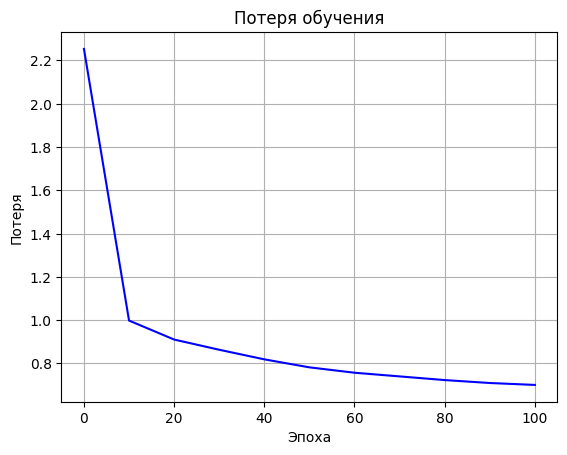

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, loss_list, 'b-')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Потеря обучения')
plt.grid(True) #добавляем сетку
plt.show()

## 2. Генерирование текста при помощи RNN

2.1 Скачайте из интернета какое-нибудь художественное произведение
  * Выбирайте достаточно крупное произведение, чтобы модель лучше обучалась;

2.2 На основе выбранного произведения создайте датасет. 

Отличия от задачи 1:
  * Токены <SOS>, `<EOS>` и `<UNK>` можно не добавлять;
  * При создании датасета текст необходимо предварительно разбить на части. Выберите желаемую длину последовательности `seq_len` и разбейте текст на построки длины `seq_len` (можно без перекрытия, можно с небольшим перекрытием).


In [ ]:
import numpy as np
import os
os.listdir() #возвращаем список файлов и папок в текущей рабочей директории

['name_rus.txt', 'The-Great-Gatsby.txt']

In [38]:
#считываем файлы
text = ""
for i in range(1, 5):
    with open(f"/content/drive/MyDrive/datasets/The-Great-Gatsby{i}.txt", 'r') as f:
        text += f.read()

In [39]:
#создаем класс, который используется для создания словаря на основе текста
class Vocab:
    def __init__(self, text):
        tokens = set(text) #создаем множество уникальных токенов из текста
        #каждому индексу (начиная с 2) сопоставляется соответствующий токен из множества tokens
        self.idx_to_token = dict(enumerate(tokens, 2))
        #индексы 0 и 1 зарезервированы для специальных токенов "<PAD>" и "<SOS>
        self.idx_to_token[0] = "<PAD>"
        self.idx_to_token[1] = "<SOS>"
        #создаем словарь token_to_idx, где каждому токену сопоставляется соответствующий индекс
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token) #общее количество токенов в словаре

In [50]:
#создаем класс, который предоставляет возможность преобразования текстовых фрагментов в числовое представление с помощью словаря
class BookDataset(Dataset):
    def __init__(self, text, vocab: Vocab, seq_len=128, shift=None):
        self.seq_len = seq_len
        self.shift = shift
        self.X = self.__text_split(text)
        self.vocab = vocab
        
    def __text_split(self, text): #в методе текст разбивается на фрагменты длиной seq_len с использованием сдвига shift
        if self.shift is None: 
            self.shift = self.seq_len // 4
        start = 0
        X = []
        while start < len(text):
            X.append(text[start:start+self.seq_len])
            start += self.shift
        return np.array(X)
    
    def vectorize(self, fragment): #метод преобразует фрагмент текста в числовое представление
        fragment_t = torch.zeros(self.seq_len+1).long() #создается тензор размерности (seq_len+1)
        fragment_t += self.vocab.token_to_idx["<PAD>"]
        for i, token in enumerate(fragment, 1):
            #каждый токен из фрагмента текста преобразуется в соответствующий индекс из словаря vocab.token_to_idx
            fragment_t[i] = self.vocab.token_to_idx[token]
        fragment_t[0] = self.vocab.token_to_idx["<SOS>"]
        return fragment_t[:-1], fragment_t[1:]

    def __len__(self): #возвращает общее количество фрагментов текста
        return len(self.X)

    def __getitem__(self, idx): #возвращает числовое представление фрагмента текста с индексом
        return self.vectorize(self.X[idx])

In [51]:
vocab = Vocab(text)
#набор данных будет использовать словарь для преобразования текста в числовое представление и разбивать текст на фрагменты заданной длины
dataset = BookDataset(text, vocab)
#создаем загрузчик данных DataLoader, который будет использоваться для эффективной загрузки данных из набора dataset
dataloader = DataLoader(dataset, batch_size=32)

2.3 Создайте и обучите модель для генерации текста
  * Задача ставится точно так же как в 1.2;
  * При необходимости можете применить:
    * двухуровневые рекуррентные слои (`num_layers`=2)
    * [обрезку градиентов](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)

2.4 Напишите функцию, которая генерирует фрагмент текста при помощи обученной модели
  * Процесс генерации начинается с небольшого фрагмента текста `prime`, выбранного вами (1-2 слова) 
  * Сначала вы пропускаете через модель токены из `prime` и генерируете на их основе скрытое состояние рекуррентного слоя `h_t`;
  * После этого вы генерируете строку нужной длины аналогично 1.3

In [52]:
#создаем модель, которая используется для генерации текста на основе заданного контекста
class MyModel(nn.Module):
    def __init__(self, vocab, embedding_dim, hidden_size, num_layers=1):
        super(MyModel, self).__init__()
        self.vocab = vocab
        #слой эмбеддингов (nn.Embedding), который отображает индексы символов в векторные представления заданной размерности
        self.embedding = nn.Embedding(padding_idx=vocab.token_to_idx["<PAD>"], num_embeddings=vocab.vocab_len, embedding_dim=embedding_dim)
        #рекуррентный слой (nn.LSTM), который обрабатывает входные последовательности и сохраняет состояние скрытого состояния
        self.rnn = nn.LSTM(num_layers=num_layers, batch_first=True, input_size=embedding_dim, hidden_size=hidden_size)
        #полносвязный слой (nn.Linear), который преобразует скрытые состояния RNN в векторные представления символов
        self.fc = nn.Linear(in_features=hidden_size, out_features=vocab.vocab_len)
        
    def forward(self, x, hc=None):#определяем проход данных через модель
        x = self.embedding(x) #тензор с индексами символов
        x, hc = self.rnn(x, hc) #скрытое состояние RNN
        x = self.fc(x) #предсказания для каждого символа в словаре
        return x, hc
    
    def gen_fragment(self, start_with, length=256): #используется для генерации фрагмента текста на основе заданного начала и длины 
        hc = None
        word = []
        token = torch.tensor([[vocab.token_to_idx["<SOS>"]]]).to(device)
        #для каждого токена в start_with, происходит прямой проход модели с текущим токеном token и скрытым состоянием hc
        for token__ in start_with:
            out, hc = self(token, hc)
            token = torch.tensor(
                [[self.vocab.token_to_idx[token__]]],
                dtype=torch.long
                ).to(device)

        for _ in range(length):
            token = token.to(device) 
            out, hc = self(token, hc) #токен передается в модель
            #полученный выход out преобразуется в распределение вероятностей через функцию softmax
            out_random = out.squeeze().softmax(-1).multinomial(1) #из распределения вероятностей выбирается токен out_random методом multinomial(1)
            letter = self.vocab.idx_to_token[out_random.item()]
            word.append(letter)
            token = out_random.view(1, 1) #токен out_random преобразуется в тензор
        #создается список clear, содержащий символы из word, за исключением специальных токенов
        clear = [letter for letter in word if letter not in ["<PAD>","<EOS>","<SOS>","<UNK>"]]
        #создается строка generated из символов в списке word, начинающаяся с заглавной буквы
        generated = "".join(word).capitalize()
        #создается строка clear, полученная из символов в списке clear, начинающаяся с заглавной буквы
        clear = "".join(clear).capitalize()
        return generated, clear

In [53]:
model = MyModel(
    vocab=vocab,
    embedding_dim=32,
    hidden_size=64,
).to(device)
criterion = nn.CrossEntropyLoss() #используется для вычисления потери (ошибки) между предсказанными значениями и истинными метками
optimizer = optim.Adam(params=model.parameters(), lr=0.001) #используется для получения параметров модели, которые будут оптимизироваться

In [54]:
#обучение модели
epoch_step = 1
n_epochs = 21
n_words = 10
epoch_list = []
loss_list = []
for epoch in range(n_epochs):
    epoch_loss = 0
    k = 0
    #переводим в режим обучения
    model.train()
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad() #очищаем градиенты 
        predictions, h = model(X_batch) #вычисляем прогнозы модели и скрытое состояние
        loss = criterion(predictions.transpose(1, -1), y_batch) #вычисляем потерю между прогнозами и целевыми значениями
        #обратное распространение ошибки и обновление параметров модели 
        loss.backward()
        optimizer.step()
        #записываем значение потери для текущей эпохи 
        epoch_loss += loss.item()
        k += 1
    epoch_loss = epoch_loss / k
    if epoch % epoch_step == 0:
        #значение потери усредняется по всем партиям данных и выводится информация о потери для текущей эпохи
        epoch_list.append(epoch)
        loss_list.append(epoch_loss)
        print(f"#{epoch:3d} --- loss [{epoch_loss:.4f}]")
        _, clear = model.gen_fragment(start_with="In my younger")
        print("".join(clear))
        #на каждой эпохе выводится информация о потери модели, а также генерируется и выводится фрагмент текста для демонстрации работы модели

#  0 --- loss [2.9379]
Er cines whe invet wo sue, tsy ane nera oood thind kn.an.e mol,. ylal gatsy eertilm“(smype”“u irat hiid ad’y an.4igh, o,d ta, aastyl r.yrpa pgela, ag wedrv thin fid pidip gout s““qodrnget tet —ed ltiiv vebsb non oo tharce ound yhe sicdt d. n’red heoouin. t
#  1 --- loss [2.4163]
Esst ofill ly re cout ad”itischked i thess thed tos. yhe” wose. voss means fats, thelt the tang the ans s iruty wous tway datt a adarth ok sreasn. i thevmezghiver ghensinsed pasry. eaty in’ve ma cid, disss toklategh one wa cteted aed”ees lened ailis tracad
#  2 --- loss [2.2684]
 tonad but qange moos es tumind homer. a bucnedsed ment pated are eis dikes sustarye?”her sad”.”soo. me knut weraflereringe stithher i devect agto aw piding yhincky toued motomo astargar ofhen fremour larn tere co the of. geaf afom the tobai kre pociy wald
#  3 --- loss [2.1704]
 in gat und ton’seated lim.“éod.”“whey ,ome. haed h ant eas of and overs maly awy greo he drost hive tincight. “niphe qhennd a loses and 

In [55]:
#продолжается обучение модели
epoch_step = 1
epoch_list2 = []
loss_list2 = []
for epoch in range(21, 41):
    epoch_loss = 0
    k = 0
    model.train()
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions, h = model(X_batch)
        loss = criterion(predictions.transpose(1, -1), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        k += 1
    epoch_loss = epoch_loss / k
    if epoch % epoch_step == 0:
        epoch_list2.append(epoch)
        loss_list2.append(epoch_loss)
        print(f"#{epoch:3d} --- loss [{epoch_loss:.4f}]")
        _, clear = model.gen_fragment(start_with="In my younger")
        print("".join(clear))

# 21 --- loss [1.7182]
S. it tain dayg that, who down dissions and she halve sagement fell in, he leven by rose from when down at it his noth, it inquice fold a bout remental that prriding his ends onoun like. “neg’re towr. “shere was swilong the mor. “mrs. bake all peclarn, and
# 22 --- loss [1.7095]
Ich bory in lown, and wittar no itwar have thatcerge he allfid gop his as years away adonce that. the handon, when the efter,” spacatic.“ferive way, left as inthely one frot.”wiles. he was or my that he made tell we star, but like of himally in the juster 
# 23 --- loss [1.7013]
E!” he dincess you good and yourded her i had, again, a.”“no?”i you’ves to be he’d gaperoun. i he froalbed of for my men. i saw revery dest all awar.”he ripding and floll zidn to the beroan them farm who meatelring the mast. “who go in vointion. merosp-shi
# 24 --- loss [1.6935]
 startself mintly in me he leps to fan and she foulling the didn’t there—and jody’t se that he didn’t what’s time a didn’t me.“i had atle

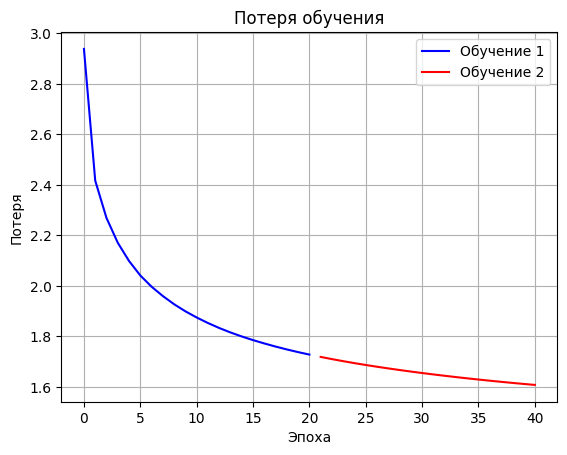

In [57]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, loss_list, 'b-', label='Обучение 1')
plt.plot(epoch_list2, loss_list2, 'r-', label='Обучение 2')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Потеря обучения')
plt.legend()
plt.grid(True) #добавляем сетку
plt.show()